<a href="https://colab.research.google.com/github/idiazp/Machine2/blob/main/Imagenes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Carga de datasets**

In [ ]:
# Paso 1: Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Paso 2: Definir la ruta donde están los archivos en tu Google Drive
folder_path = '/content/drive/MyDrive/DII/DEII707 - INDUSTRIA INTELIGENTE AVANZADA/Tarea/Datasets/'


In [ ]:
# Paso 3: Función para deserializar los archivos pickle
import pickle

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Paso 4: Cargar los datos de 'data_batch_1'
data_batch_1 = unpickle(folder_path + 'data_batch_1')

# Paso 5: Cargar los datos de 'batches.meta'
batches_meta = unpickle(folder_path + 'batches.meta')

# Paso 6: Acceder a los datos de 'data_batch_1'
data = data_batch_1[b'data']  # Las imágenes en forma de array 10000x3072
labels = data_batch_1[b'labels']  # Las etiquetas

# Paso 7: Acceder a los nombres de las etiquetas en 'batches.meta'
label_names = batches_meta[b'label_names']

# Mostrar información básica
print(f'Data shape: {data.shape}')
print(f'Labels length: {len(labels)}')
print(f'Label names: {label_names}')

Data shape: (10000, 3072)
Labels length: 10000
Label names: [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


# **Revisar dataset**

## **1. Distribución de las etiquetas**

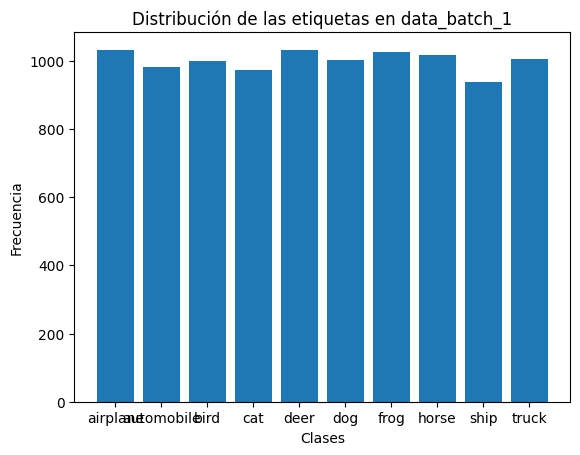

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Convertir las etiquetas en un array de numpy para análisis
labels_array = np.array(labels)

# Contar la frecuencia de cada etiqueta
label_counts = Counter(labels_array)

# Graficar la distribución de las etiquetas
plt.bar(range(len(label_names)), list(label_counts.values()), tick_label=[name.decode("utf-8") for name in label_names])
plt.title('Distribución de las etiquetas en data_batch_1')
plt.xlabel('Clases')
plt.ylabel('Frecuencia')
plt.show()


## **2. Verificar valores nulos**

In [ ]:
# Verificar si hay valores nulos en los datos
null_values = np.isnan(data).sum()
print(f'Cantidad de valores nulos en el dataset: {null_values}')


Cantidad de valores nulos en el dataset: 0


## **3. Verificar valores fuera de rango**

In [ ]:
# Verificar si hay valores fuera del rango [0, 255]
min_value = np.min(data)
max_value = np.max(data)

print(f'Valor mínimo en el dataset: {min_value}')
print(f'Valor máximo en el dataset: {max_value}')


Valor mínimo en el dataset: 0
Valor máximo en el dataset: 255


## **4. Visualizar algunas imágenes del dataset**

Etiqueta: automobile


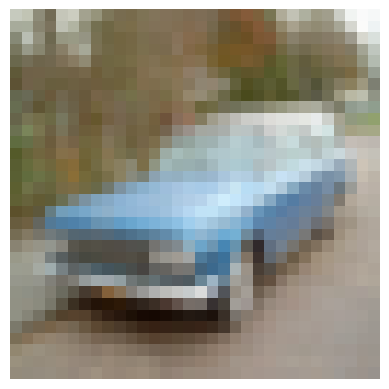

Etiqueta: automobile


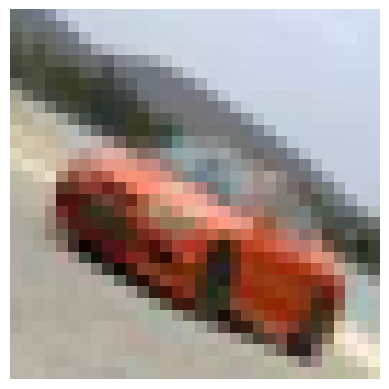

Etiqueta: dog


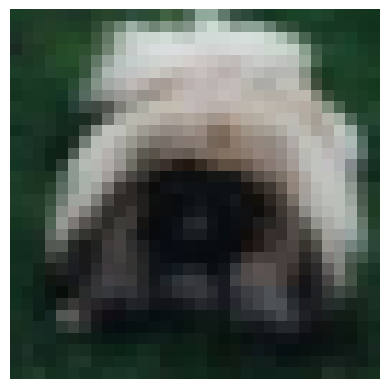

Etiqueta: automobile


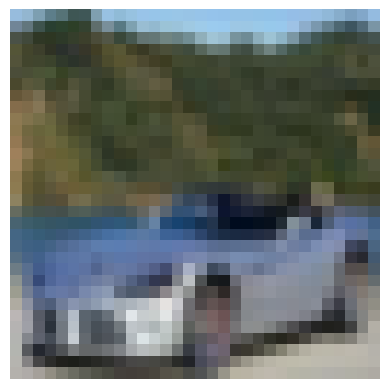

Etiqueta: automobile


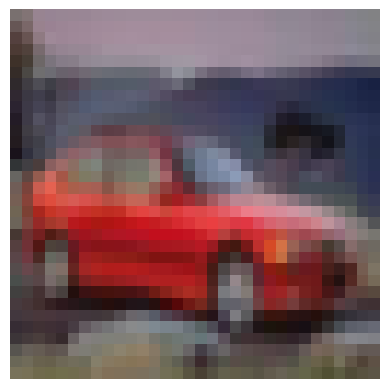

Etiqueta: cat


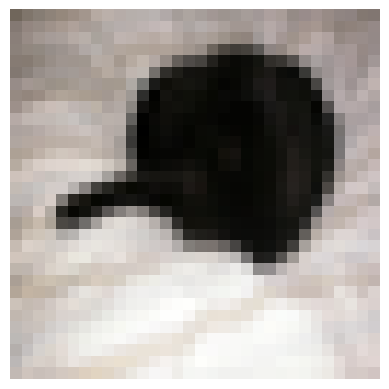

Etiqueta: automobile


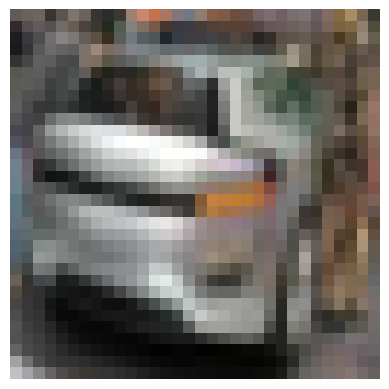

Etiqueta: airplane


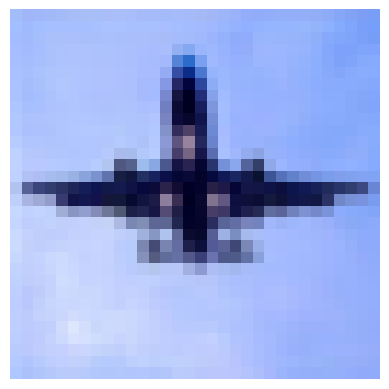

Etiqueta: cat


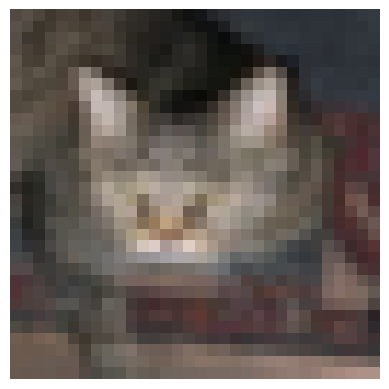

Etiqueta: horse


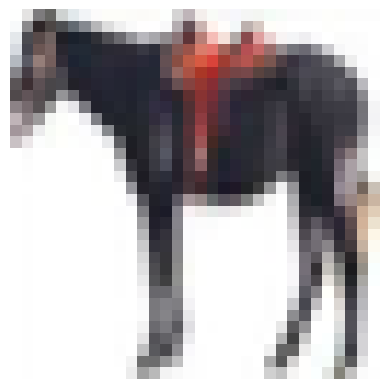

In [ ]:
# Función para mostrar una imagen
def show_image(img_data):
    img = img_data.reshape(3, 32, 32).transpose(1, 2, 0)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Mostrar 10 imágenes aleatorias del dataset
for i in range(10):
    index = np.random.randint(10000)
    print(f"Etiqueta: {label_names[labels[index]].decode('utf-8')}")
    show_image(data[index])


## **5. Calcular estadísticas descriptivas**

In [ ]:
# Calcular estadísticas descriptivas de los valores de los píxeles
mean_value = np.mean(data)
std_value = np.std(data)

print(f'Media de los valores de píxeles: {mean_value}')
print(f'Desviación estándar de los valores de píxeles: {std_value}')


Media de los valores de píxeles: 121.04103444010417
Desviación estándar de los valores de píxeles: 64.39060047846118


# **Clasificación de imágenes**

Para trabajar en la clasificación de imágenes del dataset CIFAR-10 y entrenar modelos para identificar las imágenes que correspondan a la clase 'cat', se implementará un flujo de trabajo que incluye la preparación del dataset, la construcción de un modelo de clasificación y la evaluación del mismo.

## **1. Preparación del Dataset**
Primero, necesitamos filtrar las imágenes que corresponden a la clase 'cat' y una clase "no-cat" para entrenar un modelo binario. Para simplificar, utilizaremos 'cat' (etiqueta 3) frente a todas las demás clases combinadas en una clasificación binaria.

In [ ]:
import numpy as np

# Convertir los labels en una clase binaria: 1 para 'cat' (etiqueta 3) y 0 para las demás clases
cat_label = 3
binary_labels = np.array([1 if label == cat_label else 0 for label in labels])

# Verificar la cantidad de ejemplos en cada clase
cat_count = np.sum(binary_labels)
non_cat_count = len(binary_labels) - cat_count
print(f"Cantidad de imágenes de 'cat': {cat_count}")
print(f"Cantidad de imágenes de 'no-cat': {non_cat_count}")


Cantidad de imágenes de 'cat': 1016
Cantidad de imágenes de 'no-cat': 8984


## **2. División en Conjuntos de Entrenamiento y Prueba**
Dividimos los datos en un conjunto de entrenamiento y uno de prueba. Esto permite evaluar el rendimiento del modelo de forma imparcial.

In [ ]:
from sklearn.model_selection import train_test_split

# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(data, binary_labels, test_size=0.2, random_state=42)

# Normalizar los valores de los píxeles entre 0 y 1 para mejorar el entrenamiento
X_train = X_train / 255.0
X_test = X_test / 255.0


## **3. Construcción del Modelo**
Empezamos con un modelo simple usando una red neuronal básica (MLP) para la clasificación binaria. En una etapa posterior, se podría explorar la opción de redes convolucionales (CNN).

Modelo básico: Multilayer Perceptron (MLP)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Definir el modelo
model = models.Sequential([
    layers.Flatten(input_shape=(3072,)),  # Aplanar la imagen
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Clasificación binaria
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8831 - loss: 0.3567 - val_accuracy: 0.9005 - val_loss: 0.3077
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8982 - loss: 0.3368 - val_accuracy: 0.9005 - val_loss: 0.3218
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8930 - loss: 0.3280 - val_accuracy: 0.9005 - val_loss: 0.2984
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8992 - loss: 0.3085 - val_accuracy: 0.9005 - val_loss: 0.4250
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8989 - loss: 0.3196 - val_accuracy: 0.9000 - val_loss: 0.2943
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9029 - loss: 0.2895 - val_accuracy: 0.9010 - val_loss: 0.3024
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9026 - loss: 0.2815 - val_accuracy: 0.9015 - val_loss: 0.2862
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8996 - loss: 0.2903 - val_accuracy: 0.

## **4. Evaluación del Modelo**
Después del entrenamiento, evaluamos el modelo con el conjunto de prueba para ver su rendimiento.

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test, y_test)

print(f'Precisión en el conjunto de prueba: {test_acc}')


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9011 - loss: 0.3428
Precisión en el conjunto de prueba: 0.9010000228881836


## **5. Visualización de Resultados**
Podemos graficar la evolución de la precisión y la pérdida del modelo durante el entrenamiento.

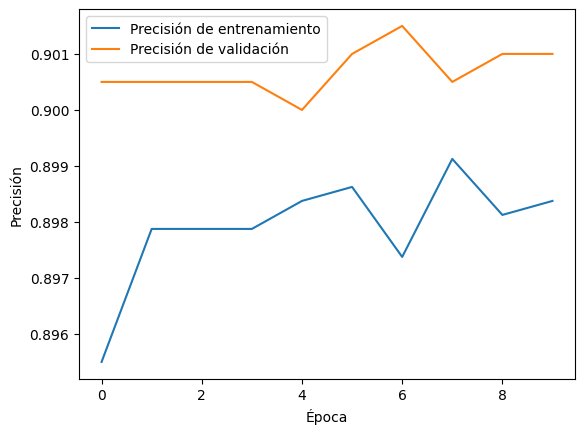

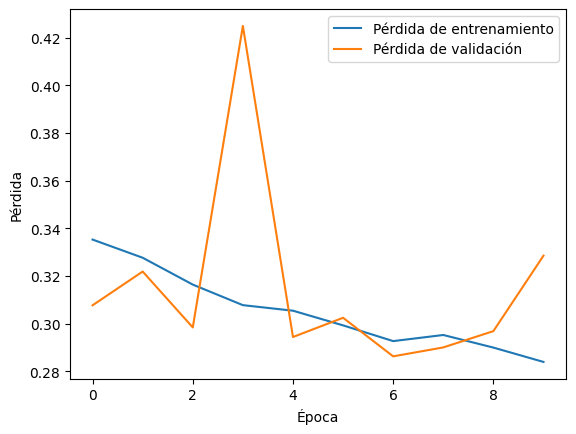

In [ ]:
# Graficar precisión
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Graficar pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


## **6. Métricas de evaluación**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convertir probabilidades en etiquetas (0 o 1)

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Matriz de Confusión:\n{conf_matrix}")

# Informe de clasificación con precisión, sensibilidad, F1 y más
class_report = classification_report(y_test, y_pred, target_names=['no-cat', 'cat'])
print(f"Informe de Clasificación:\n{class_report}")

# Calcular ROC-AUC (utilizando las probabilidades en lugar de las etiquetas binarias)
roc_auc = roc_auc_score(y_test, model.predict(X_test))
print(f"ROC-AUC: {roc_auc}")



63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Matriz de Confusión:
[[1800    1]
 [ 197    2]]
Informe de Clasificación:
              precision    recall  f1-score   support

      no-cat       0.90      1.00      0.95      1801
         cat       0.67      0.01      0.02       199

    accuracy                           0.90      2000
   macro avg       0.78      0.50      0.48      2000
weighted avg       0.88      0.90      0.86      2000

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
ROC-AUC: 0.739533313430004


1. Matriz de Confusión:
True Positives (cat): 2
False Positives (cat): 1
True Negatives (no-cat): 1800
False Negatives (no-cat): 197
El modelo tiene una alta capacidad para identificar las imágenes que no son gatos (no-cat) (1800 correctamente clasificadas), pero tiene dificultades significativas para identificar las imágenes de gatos, con solo 2 casos correctos de 199.

2. Informe de Clasificación:
Precisión para "no-cat": 0.90

El modelo tiene una alta precisión al predecir imágenes que no son de gatos, lo que significa que cuando predice "no-cat", es casi siempre correcto.
Recall para "no-cat": 1.00

El modelo es excelente en recordar todas las instancias de "no-cat", con una sensibilidad del 100%.
Precisión para "cat": 0.67

Aunque la precisión parece decente, significa que cuando el modelo predice "cat", solo el 67% de las veces es correcto (aunque el número de predicciones de "cat" es muy bajo).
Recall para "cat": 0.01

El modelo tiene serios problemas para identificar gatos, detectando solo 2 de las 199 imágenes de gatos, lo que da un recall muy bajo.
F1-Score para "cat": 0.02

La combinación de baja precisión y sensibilidad resulta en un F1-score extremadamente bajo para las imágenes de gatos.
Exactitud global (Accuracy): 0.90

El valor de exactitud global parece bueno (90%), pero esto es engañoso porque el dataset está altamente desequilibrado (muchas más imágenes de "no-cat" que de "cat"). El modelo está acertando predominantemente en las clases "no-cat", lo que no indica un buen rendimiento para la clase "cat".
3. ROC-AUC: 0.7395
El ROC-AUC es de 0.74, lo que sugiere que el modelo tiene un rendimiento moderado en la distinción entre las clases "cat" y "no-cat". Sin embargo, el desempeño real, especialmente en la clase "cat", es insuficiente, como se observa en el bajo recall y F1-score.

# **Clasificaciones de imágenes considerando solo 'cat'**

## **1. Filtrar el Dataset para "cat"**
Primero, debemos filtrar las imágenes que tienen la etiqueta 'cat' (etiqueta 3) y luego aplicar el modelo solo a estas imágenes.

In [ ]:
# Filtrar el dataset para que contenga solo imágenes de la clase 'cat'
cat_label = 3
cat_images = data[np.array(labels) == cat_label]
cat_labels = np.array(labels)[np.array(labels) == cat_label]

print(f"Total de imágenes con el label 'cat': {cat_images.shape[0]}")


Total de imágenes con el label 'cat': 1016


## **2. División del Dataset de "cat" en Entrenamiento y Prueba**
Incluso con el dataset filtrado para "cat", seguiremos dividiendo los datos en entrenamiento y prueba para poder evaluar el modelo de manera adecuada.

In [ ]:
from sklearn.model_selection import train_test_split

# Dividir los datos en entrenamiento y prueba
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(cat_images, cat_labels, test_size=0.2, random_state=42)

# Normalizar los valores de los píxeles entre 0 y 1 para el entrenamiento
X_train_cat = X_train_cat / 255.0
X_test_cat = X_test_cat / 255.0

print(f"Tamaño del conjunto de entrenamiento: {X_train_cat.shape[0]}")
print(f"Tamaño del conjunto de prueba: {X_test_cat.shape[0]}")


Tamaño del conjunto de entrenamiento: 812
Tamaño del conjunto de prueba: 204


## **3. Aplicar el Modelo a las Imágenes de "cat"**
Ahora, puedes aplicar cualquier tipo de modelo para estas imágenes, ya que todas pertenecen a la clase 'cat'. Esto podría ser útil para tareas como:

Clasificación dentro de diferentes tipos de gatos (si tuvieras etiquetas adicionales).
Identificación de patrones dentro de la clase 'cat'.
Dado que solo trabajamos con imágenes de gatos, puedes aplicar modelos de redes neuronales para ver qué tipo de características extraen de las imágenes.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Definir un modelo básico
model = models.Sequential([
    layers.Flatten(input_shape=(3072,)),  # Aplanar la imagen
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Clasificación binaria
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train_cat, y_train_cat, epochs=10, validation_data=(X_test_cat, y_test_cat))


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0000e+00 - loss: -136.5566 - val_accuracy: 0.0000e+00 - val_loss: -933.9579
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: -1594.3928 - val_accuracy: 0.0000e+00 - val_loss: -4583.6182
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: -6566.8467 - val_accuracy: 0.0000e+00 - val_loss: -14198.7461
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: -18652.0859 - val_accuracy: 0.0000e+00 - val_loss: -33915.7383
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: -42593.1367 - val_accuracy: 0.0000e+00 - val_loss: -68381.9688
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: -82165.6094 - val_accuracy: 0.0000e+00 - val_loss: -122065.5234
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: -141960.0156 - val_accuracy: 0.0000e+00 - val_loss: -200034.8281
Epoch 8

## **5. Evaluación del Modelo**
Después del entrenamiento, puedes evaluar el rendimiento del modelo en el conjunto de prueba usando el mismo proceso que antes:

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test_cat, y_test_cat)

print(f'Precisión en el conjunto de prueba: {test_acc}')


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: -627600.9375 
Precisión en el conjunto de prueba: 0.0


## **6. Métricas**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred_cat = model.predict(X_test_cat)
y_pred_cat = (y_pred_cat > 0.5).astype(int)  # Convertir probabilidades en etiquetas (0 o 1)

# Matriz de confusión
conf_matrix_cat = confusion_matrix(y_test_cat, y_pred_cat)
print(f"Matriz de Confusión:\n{conf_matrix_cat}")

# Informe de clasificación con precisión, sensibilidad, F1-Score
class_report_cat = classification_report(y_test_cat, y_pred_cat)
print(f"Informe de Clasificación:\n{class_report_cat}")

# Calcular ROC-AUC
roc_auc_cat = roc_auc_score(y_test_cat, model.predict(X_test_cat))
print(f"ROC-AUC: {roc_auc_cat}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Matriz de Confusión:
[[  0   0]
 [204   0]]
Informe de Clasificación:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       0.0
           3       0.00      0.00      0.00     204.0

    accuracy                           0.00     204.0
   macro avg       0.00      0.00      0.00     204.0
weighted avg       0.00      0.00      0.00     204.0

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

# **Clasificación usando clases balanceadas con cat y no-cat**

## **1. Filtrar imágenes de 'cat' y 'no-cat'**
Primero, filtramos las imágenes de gatos y seleccionamos una cantidad igual de imágenes de las clases "no-cat".



In [ ]:
import numpy as np

# Filtrar imágenes de gatos (etiqueta 3)
cat_label = 3
cat_images = data[np.array(labels) == cat_label]
cat_labels = np.array(labels)[np.array(labels) == cat_label]

# Filtrar imágenes de 'no-cat' (etiquetas que no son 3)
non_cat_images = data[np.array(labels) != cat_label]
non_cat_labels = np.array(labels)[np.array(labels) != cat_label]

# Tomar un número igual de imágenes 'no-cat' al número de imágenes de gatos
non_cat_images_balanced = non_cat_images[:len(cat_images)]
non_cat_labels_balanced = non_cat_labels[:len(cat_images)]

# Combinar las imágenes de 'cat' y 'no-cat'
X_balanced = np.vstack((cat_images, non_cat_images_balanced))
y_balanced = np.hstack((np.ones(len(cat_images)), np.zeros(len(non_cat_images_balanced))))

print(f'Tamaño del dataset balanceado: {X_balanced.shape[0]} imágenes')


Tamaño del dataset balanceado: 2032 imágenes


## **2. División del Dataset en Entrenamiento y Prueba**
Ahora dividimos el dataset balanceado en un conjunto de entrenamiento y uno de prueba.

In [ ]:
from sklearn.model_selection import train_test_split

# Dividir el dataset en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Normalizar los valores de los píxeles entre 0 y 1
X_train = X_train / 255.0
X_test = X_test / 255.0

print(f'Tamaño del conjunto de entrenamiento: {X_train.shape[0]}')
print(f'Tamaño del conjunto de prueba: {X_test.shape[0]}')


Tamaño del conjunto de entrenamiento: 1625
Tamaño del conjunto de prueba: 407


## **3. Definir y Entrenar el Modelo**
Usaremos un modelo MLP básico para realizar la clasificación entre 'cat' y 'no-cat'. Si prefieres usar una CNN, también podemos hacerlo en una etapa posterior.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Definir el modelo
model = models.Sequential([
    layers.Flatten(input_shape=(3072,)),  # Aplanar la imagen
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Clasificación binaria
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5588 - loss: 0.7468 - val_accuracy: 0.6585 - val_loss: 0.6259
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6545 - loss: 0.6203 - val_accuracy: 0.6511 - val_loss: 0.6198
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6105 - loss: 0.6451 - val_accuracy: 0.6585 - val_loss: 0.6002
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6744 - loss: 0.5960 - val_accuracy: 0.6708 - val_loss: 0.5913
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6584 - loss: 0.6062 - val_accuracy: 0.6364 - val_loss: 0.5936
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6961 - loss: 0.5742 - val_accuracy: 0.6609 - val_loss: 0.6175
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6678 - loss: 0.5849 - val_accuracy: 0.6290 - val_loss: 0.6554
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7092 - loss: 0.5575 - val_accuracy: 0.6806 - val_loss: 0.6007
Epo

## **4. Evaluación del Modelo**
Una vez entrenado el modelo, calculamos las métricas solicitadas.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Obtener las predicciones del modelo
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convertir probabilidades en etiquetas (0 o 1)

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Matriz de Confusión:\n{conf_matrix}")

# Informe de clasificación
class_report = classification_report(y_test, y_pred, target_names=['no-cat', 'cat'])
print(f"Informe de Clasificación:\n{class_report}")

# Calcular ROC-AUC
roc_auc = roc_auc_score(y_test, model.predict(X_test))
print(f"ROC-AUC: {roc_auc}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Matriz de Confusión:
[[136  78]
 [ 46 147]]
Informe de Clasificación:
              precision    recall  f1-score   support

      no-cat       0.75      0.64      0.69       214
         cat       0.65      0.76      0.70       193

    accuracy                           0.70       407
   macro avg       0.70      0.70      0.70       407
weighted avg       0.70      0.70      0.69       407

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
ROC-AUC: 0.7687279066389036


# **Uso de CNN para el dataset balanceado**

## **1. Ajustar las Imágenes para CNN**
Las CNN requieren que las imágenes tengan la forma original (32x32 píxeles y 3 canales de color). Actualmente, las imágenes están en forma de vector (3072), así que las remodelaremos a su formato 3D original.

In [ ]:
# Remodelar las imágenes a su forma original: (n_samples, 32, 32, 3)
X_train_cnn = X_train.reshape(-1, 32, 32, 3)
X_test_cnn = X_test.reshape(-1, 32, 32, 3)

print(f"Nueva forma del conjunto de entrenamiento: {X_train_cnn.shape}")
print(f"Nueva forma del conjunto de prueba: {X_test_cnn.shape}")


Nueva forma del conjunto de entrenamiento: (1625, 32, 32, 3)
Nueva forma del conjunto de prueba: (407, 32, 32, 3)


## **2. Definir el Modelo CNN**
Aquí está el código para definir una CNN básica con varias capas convolucionales y de pooling, seguida de capas densas para la clasificación binaria.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Definir la arquitectura de la CNN
model = models.Sequential()

# Primera capa convolucional
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Segunda capa convolucional
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Tercera capa convolucional
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Aplanar y conectar con capas densas
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Clasificación binaria

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Mostrar resumen del modelo
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_108 (Conv2D)                  │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_107 (MaxPooling2D)     │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_109 (Conv2D)                  │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_108 (MaxPooling2D)     │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_110 (Conv2D)                  │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_38 (Flatten)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_78 (Dense)                     │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_79 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121,985 (476.50 KB)

 Trainable params: 121,985 (476.50 KB)

 Non-trainable params: 0 (0.00 B)

## **3. Entrenar la CNN**
Ahora entrenamos el modelo con el dataset balanceado.

In [ ]:
# Entrenar la CNN
history = model.fit(X_train_cnn, y_train, epochs=10, validation_data=(X_test_cnn, y_test))


Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5614 - loss: 0.6842 - val_accuracy: 0.6241 - val_loss: 0.6386
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6082 - loss: 0.6401 - val_accuracy: 0.6683 - val_loss: 0.6146
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6609 - loss: 0.6005 - val_accuracy: 0.7052 - val_loss: 0.5831
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6842 - loss: 0.5825 - val_accuracy: 0.7125 - val_loss: 0.5514
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6973 - loss: 0.5457 - val_accuracy: 0.7248 - val_loss: 0.5464
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7592 - loss: 0.4933 - val_accuracy: 0.7101 - val_loss: 0.5980
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7689 - loss: 0.4801 - val_accuracy: 0.7322 - val_loss: 0.5637
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7949 - loss: 0.4253 - val_accuracy: 0.7469 - v

## **4. Evaluar el Modelo y Generar Métricas**
Después del entrenamiento, evaluamos el modelo y calculamos las métricas solicitadas.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred_cnn = model.predict(X_test_cnn)
y_pred_cnn = (y_pred_cnn > 0.5).astype(int)  # Convertir probabilidades en etiquetas (0 o 1)

# Matriz de confusión
conf_matrix_cnn = confusion_matrix(y_test, y_pred_cnn)
print(f"Matriz de Confusión:\n{conf_matrix_cnn}")

# Informe de clasificación
class_report_cnn = classification_report(y_test, y_pred_cnn, target_names=['no-cat', 'cat'])
print(f"Informe de Clasificación:\n{class_report_cnn}")

# Calcular ROC-AUC
roc_auc_cnn = roc_auc_score(y_test, model.predict(X_test_cnn))
print(f"ROC-AUC: {roc_auc_cnn}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Matriz de Confusión:
[[145  69]
 [ 33 160]]
Informe de Clasificación:
              precision    recall  f1-score   support

      no-cat       0.81      0.68      0.74       214
         cat       0.70      0.83      0.76       193

    accuracy                           0.75       407
   macro avg       0.76      0.75      0.75       407
weighted avg       0.76      0.75      0.75       407

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
ROC-AUC: 0.8234468064500508


# **Ajuste de hiperparámetros de la CNN**

## **1. Ajuste inicial**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Ajustar la tasa de aprendizaje con un optimizador Adam modificado
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Definir un modelo CNN con más capas, más filtros, y Dropout
model = models.Sequential()

# Primera capa convolucional
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Segunda capa convolucional
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Tercera capa convolucional
model.add(layers.Conv2D(128, (3, 3), activation='relu'))

# Cuarta capa convolucional
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Aplanar y conectar con capas densas
model.add(layers.Flatten())

# Capa densa con Dropout para prevenir el sobreajuste
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  # Desactiva aleatoriamente el 50% de las neuronas

# Capa de salida
model.add(layers.Dense(1, activation='sigmoid'))

# Compilar el modelo con la nueva tasa de aprendizaje
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Mostrar el resumen del modelo
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 30, 30, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 2, 2, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 551,425 (2.10 MB)

 Trainable params: 551,425 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

## **2. Aplicación del modelo**

In [ ]:
# Entrenar el modelo
history = model.fit(X_train_cnn, y_train, epochs=20, batch_size=64, validation_data=(X_test_cnn, y_test))



Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - accuracy: 0.5171 - loss: 0.6932 - val_accuracy: 0.5356 - val_loss: 0.6876
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - accuracy: 0.5475 - loss: 0.6869 - val_accuracy: 0.6486 - val_loss: 0.6813
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - accuracy: 0.6077 - loss: 0.6767 - val_accuracy: 0.5135 - val_loss: 0.6827
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.5990 - loss: 0.6700 - val_accuracy: 0.5479 - val_loss: 0.6781
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step - accuracy: 0.6258 - loss: 0.6487 - val_accuracy: 0.6683 - val_loss: 0.6366
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.6258 - loss: 0.6403 - val_accuracy: 0.6757 - val_loss: 0.6177
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.6192 - loss: 0.6374 - val_accuracy: 0.6781 - val_loss: 0.6221
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - accuracy: 0.6512 - loss: 0.6121 - val_accuracy: 0.

## **3. Evaluación de métricas**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred_cnn = model.predict(X_test_cnn)
y_pred_cnn = (y_pred_cnn > 0.5).astype(int)  # Convertir probabilidades en etiquetas (0 o 1)

# Matriz de confusión
conf_matrix_cnn = confusion_matrix(y_test, y_pred_cnn)
print(f"Matriz de Confusión:\n{conf_matrix_cnn}")

# Informe de clasificación
class_report_cnn = classification_report(y_test, y_pred_cnn, target_names=['no-cat', 'cat'])
print(f"Informe de Clasificación:\n{class_report_cnn}")

# Calcular ROC-AUC
roc_auc_cnn = roc_auc_score(y_test, model.predict(X_test_cnn))
print(f"ROC-AUC: {roc_auc_cnn}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Matriz de Confusión:
[[112 102]
 [ 14 179]]
Informe de Clasificación:
              precision    recall  f1-score   support

      no-cat       0.89      0.52      0.66       214
         cat       0.64      0.93      0.76       193

    accuracy                           0.71       407
   macro avg       0.76      0.73      0.71       407
weighted avg       0.77      0.71      0.70       407

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
ROC-AUC: 0.8052636676190015


1. Matriz de Confusión:
True Negatives (no-cat): 112
False Positives (no-cat predicho incorrectamente como 'cat'): 102
False Negatives (cat predicho incorrectamente como 'no-cat'): 14
True Positives (cat): 179
El modelo ha mejorado considerablemente en la detección de imágenes de gatos, reduciendo significativamente los falsos negativos (solo 14), lo que sugiere que el modelo ahora reconoce mejor las imágenes de "cat". Sin embargo, ha incrementado los falsos positivos, lo que indica que está clasificando más imágenes de "no-cat" como "cat".

2. Informe de Clasificación:
Precisión para "no-cat": 0.89

La precisión para "no-cat" es alta, lo que indica que cuando el modelo predice "no-cat", es correcto el 89% de las veces.
Recall para "no-cat": 0.52

El modelo está perdiendo muchas imágenes de "no-cat", lo que se refleja en un recall bajo. Esto sugiere que, aunque las predicciones de "no-cat" son precisas cuando se hacen, el modelo está clasificando demasiadas imágenes de "no-cat" como "cat" (muchos falsos positivos).
Precisión para "cat": 0.64

La precisión para "cat" es más baja que para "no-cat", lo que indica que el modelo comete algunos errores al clasificar "cat". Sin embargo, es aún un buen valor, dado que la clase "cat" se detecta correctamente en la mayoría de los casos.
Recall para "cat": 0.93

Este es un gran valor para "cat". El modelo reconoce correctamente el 93% de las imágenes de gatos, lo que indica que está haciendo un trabajo mucho mejor detectando "cat" en comparación con el modelo previo.
F1-Score para "cat": 0.76

La combinación de una buena precisión y un excelente recall para "cat" da como resultado un buen F1-score. Este valor es sólido, lo que indica que el modelo es capaz de clasificar "cat" de manera efectiva.
Exactitud global (Accuracy): 0.71

La exactitud global ha mejorado un poco (71%), lo que refleja una mejora en el rendimiento general del modelo.
3. ROC-AUC: 0.81
ROC-AUC es 0.81, lo que sigue siendo una buena métrica de desempeño general. Esto muestra que el modelo tiene una capacidad razonable para distinguir entre las clases "cat" y "no-cat".
Análisis y Conclusión:
Mejora en la detección de "cat": El modelo es ahora mucho mejor en identificar correctamente imágenes de gatos, como lo indica el alto recall (0.93).
Problemas con los falsos positivos: El modelo está clasificando erróneamente muchas imágenes de "no-cat" como "cat" (102 falsos positivos). Esto podría ser un área para seguir mejorando, posiblemente ajustando más la red o usando técnicas adicionales.

# **Ajuste de umbral**

Ajustar el umbral de decisión te permitirá controlar la forma en que el modelo clasifica las imágenes. Actualmente, el modelo utiliza un umbral estándar de 0.5 para convertir probabilidades en etiquetas. Si ajustamos este umbral, podemos cambiar el equilibrio entre precisión y recall.

Pasos para ajustar el umbral de decisión:
Calcular las probabilidades predichas por el modelo en lugar de usar etiquetas directamente.
Probar diferentes umbrales y ver cómo cambian las métricas.
Evaluar el mejor umbral en función de la métrica que más te interese (como maximizar la precisión, recall, o un balance entre ambas).

## **1. Obtener predicciones con probabilidades**
En lugar de convertir directamente las probabilidades en etiquetas con un umbral de 0.5, vamos a obtener las probabilidades y luego probar diferentes umbrales.

In [ ]:
# Obtener las probabilidades predichas por el modelo
y_prob_cnn = model.predict(X_test_cnn)  # Esto devuelve probabilidades


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


## **2. Función para probar diferentes umbrales**
Creamos una función para aplicar diferentes umbrales y evaluar el desempeño del modelo.

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

def evaluate_with_threshold(y_true, y_prob, threshold):
    # Aplicar el umbral para convertir probabilidades en etiquetas
    y_pred_threshold = (y_prob > threshold).astype(int)

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_true, y_pred_threshold)
    print(f"\nMatriz de Confusión con umbral {threshold}:\n{conf_matrix}")

    # Informe de clasificación
    class_report = classification_report(y_true, y_pred_threshold, target_names=['no-cat', 'cat'])
    print(f"Informe de Clasificación con umbral {threshold}:\n{class_report}")

    # Calcular ROC-AUC
    roc_auc = roc_auc_score(y_true, y_prob)
    print(f"ROC-AUC con umbral {threshold}: {roc_auc}")

# Probar con umbrales diferentes (por ejemplo, 0.3, 0.5, 0.7)
evaluate_with_threshold(y_test, y_prob_cnn, threshold=0.3)
evaluate_with_threshold(y_test, y_prob_cnn, threshold=0.5)
evaluate_with_threshold(y_test, y_prob_cnn, threshold=0.7)



Matriz de Confusión con umbral 0.3:
[[ 49 165]
 [  0 193]]
Informe de Clasificación con umbral 0.3:
              precision    recall  f1-score   support

      no-cat       1.00      0.23      0.37       214
         cat       0.54      1.00      0.70       193

    accuracy                           0.59       407
   macro avg       0.77      0.61      0.54       407
weighted avg       0.78      0.59      0.53       407

ROC-AUC con umbral 0.3: 0.8052636676190015

Matriz de Confusión con umbral 0.5:
[[112 102]
 [ 14 179]]
Informe de Clasificación con umbral 0.5:
              precision    recall  f1-score   support

      no-cat       0.89      0.52      0.66       214
         cat       0.64      0.93      0.76       193

    accuracy                           0.71       407
   macro avg       0.76      0.73      0.71       407
weighted avg       0.77      0.71      0.70       407

ROC-AUC con umbral 0.5: 0.8052636676190015

Matriz de Confusión con umbral 0.7:
[[168  46]
 [ 70 123]

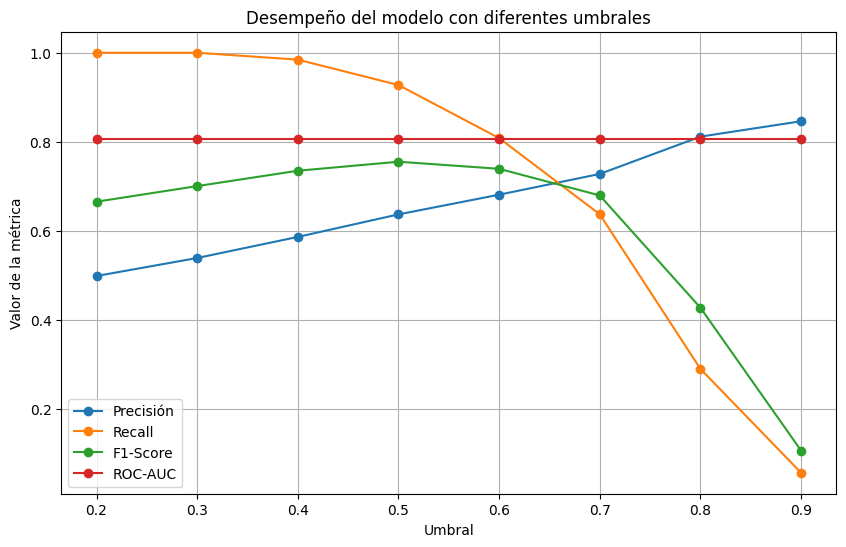

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

# Asegúrate de tener las predicciones probabilísticas y las etiquetas verdaderas
# y_prob_cnn: probabilidades predichas por el modelo CNN en el conjunto de prueba
# y_test: las etiquetas verdaderas del conjunto de prueba

# Lista de umbrales a probar
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Listas para almacenar los valores de precisión, recall, f1-score y ROC-AUC para cada umbral
precisions = []
recalls = []
f1_scores = []
roc_aucs = []

# Función para calcular las métricas con un umbral dado
def calculate_metrics(y_true, y_prob, threshold):
    y_pred = (y_prob > threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    roc_auc = roc_auc_score(y_true, y_prob)
    return precision, recall, f1, roc_auc

# Calcular las métricas para cada umbral
for threshold in thresholds:
    precision, recall, f1, roc_auc = calculate_metrics(y_test, y_prob_cnn, threshold)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    roc_aucs.append(roc_auc)

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precisión', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.plot(thresholds, f1_scores, label='F1-Score', marker='o')
plt.plot(thresholds, roc_aucs, label='ROC-AUC', marker='o')

plt.title('Desempeño del modelo con diferentes umbrales')
plt.xlabel('Umbral')
plt.ylabel('Valor de la métrica')
plt.legend()
plt.grid(True)
plt.show()


# **Uso de transferlearning con inception (googleNet)**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Paso 1: Cargar el modelo InceptionV3 preentrenado, sin las capas superiores
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Paso 2: Congelar las capas del modelo preentrenado para que no se entrenen
for layer in base_model.layers:
    layer.trainable = False

# Paso 3: Añadir nuevas capas densas para la clasificación binaria
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Aplanar las características extraídas
x = Dense(128, activation='relu')(x)  # Capa densa
predictions = Dense(1, activation='sigmoid')(x)  # Capa de salida para clasificación binaria

# Paso 4: Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Paso 5: Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Paso 6: Mostrar un resumen del modelo
model.summary()

# Paso 7: Entrenar el modelo utilizando Data Augmentation para mejorar la generalización
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# Ajustar el generador de datos al conjunto de entrenamiento
datagen.fit(X_train_cnn)

# Entrenar el modelo
history = model.fit(datagen.flow(X_train_cnn, y_train, batch_size=64),
                    validation_data=(X_test_cnn, y_test), epochs=10)

# Paso 8: Evaluar el modelo en el conjunto de prueba
y_prob = model.predict(X_test_cnn)
y_pred = (y_prob > 0.5).astype(int)  # Convertir probabilidades en etiquetas binarias

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Matriz de Confusión:\n{conf_matrix}")

# Informe de clasificación
class_report = classification_report(y_test, y_pred, target_names=['no-cat', 'cat'])
print(f"Informe de Clasificación:\n{class_report}")

# Calcular ROC-AUC
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC: {roc_auc}")


ValueError: Input size must be at least 75x75; Received: input_shape=(32, 32, 3)

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Cargar el modelo preentrenado InceptionV3 sin las capas de clasificación superiores
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas para la clasificación binaria (cat vs no-cat)
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling en lugar de aplanar
x = Dense(1024, activation='relu')(x)  # Capa totalmente conectada
predictions = Dense(1, activation='sigmoid')(x)  # Capa de salida para clasificación binaria

# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo con un optimizador Adam y binary crossentropy
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Mostrar un resumen del modelo
model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_333"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_39            │ (None, 75, 75, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_111 (Conv2D)       │ (None, 37, 37, 32)     │            864 │ input_layer_39[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 37, 37, 32)     │             96 │ conv2d_111[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 37, 37, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_112 (Conv2D)       │ (None, 35, 35, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 35, 35, 32)     │             96 │ conv2d_112[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 35, 35, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_113 (Conv2D)       │ (None, 35, 35, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 35, 35, 64)     │            192 │ conv2d_113[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 35, 35, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_109         │ (None, 17, 17, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_114 (Conv2D)       │ (None, 17, 17, 80)     │          5,120 │ max_pooling2d_109[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 17, 17, 80)     │            240 │ conv2d_114[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 17, 17, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_115 (Conv2D)       │ (None, 15, 15, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 15, 15, 192)    │            576 │ conv2d_115[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 23,901,985 (91.18 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
import cv2
import numpy as np

# Redimensionar el conjunto de entrenamiento y prueba
X_train_resized = np.array([cv2.resize(img, (75, 75)) for img in X_train_cnn])
X_test_resized = np.array([cv2.resize(img, (75, 75)) for img in X_test_cnn])

print(f"Nueva forma de X_train_resized: {X_train_resized.shape}")
print(f"Nueva forma de X_test_resized: {X_test_resized.shape}")


Nueva forma de X_train_resized: (1625, 75, 75, 3)
Nueva forma de X_test_resized: (407, 75, 75, 3)


In [ ]:
# Entrenar el modelo con las imágenes redimensionadas
history = model.fit(X_train_resized, y_train, epochs=10, batch_size=32, validation_data=(X_test_resized, y_test))


Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 172ms/step - accuracy: 0.5814 - loss: 0.7232 - val_accuracy: 0.6806 - val_loss: 0.6166
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.6991 - loss: 0.5784 - val_accuracy: 0.6781 - val_loss: 0.6042
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.7743 - loss: 0.5023 - val_accuracy: 0.6781 - val_loss: 0.6104
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.8000 - loss: 0.4597 - val_accuracy: 0.6855 - val_loss: 0.6060
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.8545 - loss: 0.4083 - val_accuracy: 0.6904 - val_loss: 0.6040
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.8767 - loss: 0.3818 - val_accuracy: 0.6830 - val_loss: 0.6081
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.8970 - loss: 0.3519 - val_accuracy: 0.7027 - val_loss: 0.6112
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.9002 - loss: 0.3379 - val_accuracy: 0

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Obtener las predicciones en el conjunto de prueba
y_pred_inception = model.predict(X_test_resized)
y_pred_inception = (y_pred_inception > 0.5).astype(int)

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_inception)
print(f"Matriz de Confusión:\n{conf_matrix}")

# Informe de clasificación
class_report = classification_report(y_test, y_pred_inception, target_names=['no-cat', 'cat'])
print(f"Informe de Clasificación:\n{class_report}")

# Calcular ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_inception)
print(f"ROC-AUC: {roc_auc}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 274ms/step
Matriz de Confusión:
[[148  66]
 [ 72 121]]
Informe de Clasificación:
              precision    recall  f1-score   support

      no-cat       0.67      0.69      0.68       214
         cat       0.65      0.63      0.64       193

    accuracy                           0.66       407
   macro avg       0.66      0.66      0.66       407
weighted avg       0.66      0.66      0.66       407

ROC-AUC: 0.6592658951140381


# **Uso de Data Augmentation**

 aplicar Data Augmentation a la CNN que utilizaste previamente y ajustar el umbral a 0.5 para obtener un mejor rendimiento. Data Augmentation generará nuevas imágenes a partir de las existentes mediante transformaciones como rotaciones, cambios de escala, y espejados, lo que puede ayudar al modelo a generalizar mejor.

Pasos a seguir:
Data Augmentation: Implementaremos técnicas de aumento de datos en el conjunto de entrenamiento.
Entrenamiento del modelo CNN: Entrenaremos el modelo con los datos aumentados.
Evaluación con umbral 0.5: Evaluaremos el rendimiento del modelo ajustando el umbral de decisión a 0.5.

## **1. Asegúrate de que la arquitectura del modelo CNN esté ajustada para imágenes de 32x32**


In [ ]:
from tensorflow.keras import layers, models

# Definir el modelo CNN ajustado para 32x32
model = models.Sequential()

# Primera capa convolucional
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Segunda capa convolucional
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Tercera capa convolucional
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Aplanar y conectar con capas densas
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Clasificación binaria

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Mostrar un resumen del modelo
model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_205 (Conv2D)                  │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_113 (MaxPooling2D)     │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_206 (Conv2D)                  │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_114 (MaxPooling2D)     │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_207 (Conv2D)                  │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_115 (MaxPooling2D)     │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_39 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_82 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_83 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 159,041 (621.25 KB)

 Trainable params: 159,041 (621.25 KB)

 Non-trainable params: 0 (0.00 B)

## **2. Continuar con Data Augmentation y entrenamiento:**
Ahora que tienes el modelo ajustado para imágenes de 32x32, puedes continuar con el código de Data Augmentation y entrenamiento.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Crear un generador de imágenes con Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,        # Rotar las imágenes hasta 20 grados
    width_shift_range=0.2,    # Desplazamiento horizontal del 20%
    height_shift_range=0.2,   # Desplazamiento vertical del 20%
    shear_range=0.2,          # Aplicar cizallamiento
    zoom_range=0.2,           # Aplicar zoom
    horizontal_flip=True,     # Voltear las imágenes horizontalmente
    fill_mode='nearest'       # Rellenar los píxeles vacíos resultantes
)

# Ajustar el generador a los datos de entrenamiento
datagen.fit(X_train_cnn)

# Entrenar el modelo CNN con Data Augmentation
history = model.fit(datagen.flow(X_train_cnn, y_train, batch_size=64),
                    epochs=10, validation_data=(X_test_cnn, y_test))


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.5159 - loss: 0.6926 - val_accuracy: 0.5307 - val_loss: 0.6897
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.5603 - loss: 0.6871 - val_accuracy: 0.5405 - val_loss: 0.6846
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5793 - loss: 0.6712 - val_accuracy: 0.5921 - val_loss: 0.6679
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6252 - loss: 0.6513 - val_accuracy: 0.6462 - val_loss: 0.6326
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.6299 - loss: 0.6350 - val_accuracy: 0.5971 - val_loss: 0.6674
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5964 - loss: 0.6592 - val_accuracy: 0.6585 - val_loss: 0.6083
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.6573 - loss: 0.6115 - val_accuracy: 0.6855 - val_loss: 0.6177
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.6582 - loss: 0.6139 - val_accuracy: 0.6364 - val_loss: 0.

## **3. Evaluación del modelo con umbral 0.5:**
Luego, puedes continuar con la evaluación utilizando el umbral de decisión 0.5:

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Obtener las predicciones del modelo (probabilidades)
y_prob_cnn = model.predict(X_test_cnn)

# Aplicar el umbral 0.5
y_pred_cnn = (y_prob_cnn > 0.5).astype(int)

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_cnn)
print(f"Matriz de Confusión:\n{conf_matrix}")

# Informe de clasificación
class_report = classification_report(y_test, y_pred_cnn, target_names=['no-cat', 'cat'])
print(f"Informe de Clasificación:\n{class_report}")

# Calcular ROC-AUC
roc_auc = roc_auc_score(y_test, y_prob_cnn)
print(f"ROC-AUC: {roc_auc}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Matriz de Confusión:
[[131  83]
 [ 40 153]]
Informe de Clasificación:
              precision    recall  f1-score   support

      no-cat       0.77      0.61      0.68       214
         cat       0.65      0.79      0.71       193

    accuracy                           0.70       407
   macro avg       0.71      0.70      0.70       407
weighted avg       0.71      0.70      0.70       407

ROC-AUC: 0.7574693719432474


# **Ajuste de hiperparámetros con RandomizedSearcCV**

## **1. Crear el modelo CNN ajustable**
Definimos una función que crea el modelo CNN con hiperparámetros ajustables para que RandomizedSearchCV pueda explorar distintas combinaciones.

In [ ]:
!pip install --upgrade scikit-learn



In [ ]:
!pip install scikeras[tensorflow]



In [ ]:
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import layers, models

# Función para crear la CNN con hiperparámetros ajustables
def create_model(activation='relu', optimizer='adam'):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation=activation, input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation=activation))
    model.add(layers.Dense(1, activation='sigmoid'))  # Clasificación binaria

    # Compilar el modelo
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model




## **2. Definir los parámetros en el constructor de KerasClassifier:**
Ahora debes pasar los hiperparámetros ajustables directamente en el constructor de KerasClassifier.

In [ ]:
# Definir el modelo KerasClassifier
model = KerasClassifier(model=create_model, verbose=0)

# Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    'batch_size': [32, 64, 128],
    'epochs': [10, 20, 30],
    'optimizer': ['adam', 'rmsprop', 'sgd'],
    'model__activation': ['relu', 'tanh']  # Asegurarse de que 'activation' se pasa correctamente
}

# Inicializar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3)



## **3. Ejecutar el RandomizedSearch:**

In [ ]:
# Ejecutar el RandomizedSearchCV
random_result = random_search.fit(X_train_cnn, y_train)

# Imprimir los mejores parámetros y el mejor resultado
print(f"Mejores parámetros encontrados: {random_result.best_params_}")
print(f"Mejor precisión: {random_result.best_score_}")



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regulariz

Mejores parámetros encontrados: {'optimizer': 'adam', 'model__activation': 'tanh', 'epochs': 30, 'batch_size': 128}
Mejor precisión: 0.7113756812244648


## **4. Evaluar el modelo con los mejores hiperparámetros:**

In [ ]:
# Evaluar el modelo con el mejor conjunto de hiperparámetros
best_model = random_result.best_estimator_

# Obtener las predicciones (clases) y las probabilidades
y_pred_best = best_model.predict(X_test_cnn)
y_prob_best = best_model.predict_proba(X_test_cnn)[:, 1]  # Obtener las probabilidades para la clase positiva (cat)

# Matriz de confusión e informe de clasificación
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_best)
print(f"Matriz de Confusión:\n{conf_matrix}")

# Informe de clasificación
class_report = classification_report(y_test, y_pred_best, target_names=['no-cat', 'cat'])
print(f"Informe de Clasificación:\n{class_report}")

# Calcular ROC-AUC
roc_auc = roc_auc_score(y_test, y_prob_best)
print(f"ROC-AUC: {roc_auc}")





Matriz de Confusión:
[[140  74]
 [ 53 140]]
Informe de Clasificación:
              precision    recall  f1-score   support

      no-cat       0.73      0.65      0.69       214
         cat       0.65      0.73      0.69       193

    accuracy                           0.69       407
   macro avg       0.69      0.69      0.69       407
weighted avg       0.69      0.69      0.69       407

ROC-AUC: 0.7806885865091278


## **5. Data augmentation con los mejores parámetros**

In [ ]:
# 1. Generador de Data Augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Crear un generador de imágenes con Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,        # Rotar las imágenes hasta 20 grados
    width_shift_range=0.2,    # Desplazamiento horizontal del 20%
    height_shift_range=0.2,   # Desplazamiento vertical del 20%
    shear_range=0.2,          # Aplicar cizallamiento
    zoom_range=0.2,           # Aplicar zoom
    horizontal_flip=True,     # Voltear las imágenes horizontalmente
    fill_mode='nearest'       # Rellenar los píxeles vacíos resultantes
)

# Ajustar el generador a los datos de entrenamiento
datagen.fit(X_train_cnn)


In [ ]:
# 2. Entrenar el modelo con Data Augmentation utilizando los mejores hiperparámetros
# Crear el modelo con los mejores hiperparámetros
best_model = create_model(optimizer='adam', activation='tanh')

# Entrenar el modelo CNN con Data Augmentation
history = best_model.fit(datagen.flow(X_train_cnn, y_train, batch_size=128),
                         epochs=30, validation_data=(X_test_cnn, y_test))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.4861 - loss: 0.7581 - val_accuracy: 0.5602 - val_loss: 0.6856
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.5397 - loss: 0.6857 - val_accuracy: 0.5455 - val_loss: 0.6838
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.6049 - loss: 0.6592 - val_accuracy: 0.6511 - val_loss: 0.6397
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.6395 - loss: 0.6434 - val_accuracy: 0.6511 - val_loss: 0.6305
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.6360 - loss: 0.6402 - val_accuracy: 0.6167 - val_loss: 0.6619
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.6163 - loss: 0.6447 - val_accuracy: 0.6241 - val_loss: 0.6299
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.6506 - loss: 0.6209 - val_accuracy: 0.6732 - val_loss: 0.6278
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.6327 - loss: 0.6260 - val_accuracy: 0.6732 - val_loss: 0.

In [ ]:
# 3. Evaluar el rendimiento y calcular las métricas (incluyendo ROC-AUC)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Obtener las predicciones (clases) y las probabilidades
y_pred_aug = (best_model.predict(X_test_cnn) > 0.5).astype(int)  # Convertir las probabilidades a etiquetas
y_prob_aug = best_model.predict(X_test_cnn)  # Obtener las probabilidades para calcular ROC-AUC

# Matriz de confusión
conf_matrix_aug = confusion_matrix(y_test, y_pred_aug)
print(f"Matriz de Confusión con Data Augmentation:\n{conf_matrix_aug}")

# Informe de clasificación
class_report_aug = classification_report(y_test, y_pred_aug, target_names=['no-cat', 'cat'])
print(f"Informe de Clasificación con Data Augmentation:\n{class_report_aug}")

# Calcular ROC-AUC
roc_auc_aug = roc_auc_score(y_test, y_prob_aug)
print(f"ROC-AUC con Data Augmentation: {roc_auc_aug}")



13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Matriz de Confusión con Data Augmentation:
[[185  29]
 [113  80]]
Informe de Clasificación con Data Augmentation:
              precision    recall  f1-score   support

      no-cat       0.62      0.86      0.72       214
         cat       0.73      0.41      0.53       193

    accuracy                           0.65       407
   macro avg       0.68      0.64      0.63       407
weighted avg       0.67      0.65      0.63       407

ROC-AUC con Data Augmentation: 0.7706164350394653


# **Uso de ensamblado de modelos**
El ensamblado de modelos combina las predicciones de varios modelos para obtener una mejor generalización y precisión en tareas de clasificación.

Pasos para hacer un Ensamblado de Modelos:
1. Entrenar los modelos individuales: Entrenar una CNN, un Random Forest, y un XGBoost por separado.
2. Obtener las predicciones de cada modelo: Para cada modelo, generar las predicciones.
3. Ensamblar las predicciones: Combinar las predicciones de cada modelo. Puedes hacerlo por:
* Votación mayoritaria: Las predicciones se basan en la mayoría de las predicciones de los modelos.
* Promedio ponderado: Las predicciones se promedian ponderando más aquellos modelos que tengan mejor rendimiento.
4. Evaluar el rendimiento del ensamblado: Medir la precisión, recall, F1-score, y ROC-AUC del modelo ensamblado.

## **Paso 1: Entrenar los Modelos Individuales**

### 1.1 **CNN**

In [ ]:
from tensorflow.keras import layers, models

# Definir el modelo CNN
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(128, activation='relu'))
cnn_model.add(layers.Dense(1, activation='sigmoid'))

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo CNN
cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=64, validation_data=(X_test_cnn, y_test))


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4952 - loss: 0.7013 - val_accuracy: 0.5356 - val_loss: 0.6806
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5529 - loss: 0.6767 - val_accuracy: 0.6241 - val_loss: 0.6450
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6008 - loss: 0.6479 - val_accuracy: 0.6609 - val_loss: 0.6255
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6657 - loss: 0.6017 - val_accuracy: 0.6757 - val_loss: 0.5839
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6736 - loss: 0.6039 - val_accuracy: 0.7027 - val_loss: 0.5628
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7026 - loss: 0.5496 - val_accuracy: 0.7150 - val_loss: 0.5761
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7250 - loss: 0.5246 - val_accuracy: 0.7052 - val_loss: 0.5544
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7388 - loss: 0.5044 - val_accuracy: 0.7248 - val_loss: 0.

### **1.2 Random Forest**
Entrena un modelo de Random Forest usando características extraídas de la CNN preentrenada (sin las capas de salida).

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Extraer características del modelo CNN (sin las capas finales)
features_train = cnn_model.predict(X_train_cnn)
features_test = cnn_model.predict(X_test_cnn)

# Entrenar un modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(features_train, y_train)

# Obtener predicciones del Random Forest
y_pred_rf = rf_model.predict(features_test)


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


### **1.3 XGBoost**
Entrena un modelo de XGBoost con las características extraídas de la CNN.

In [ ]:
import xgboost as xgb

# Crear el dataset de XGBoost
dtrain = xgb.DMatrix(features_train, label=y_train)
dtest = xgb.DMatrix(features_test)

# Entrenar un modelo XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False)
xgb_model.fit(features_train, y_train)

# Obtener predicciones de XGBoost
y_pred_xgb = xgb_model.predict(features_test)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:37:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## **Paso 2: Obtener las Predicciones de los Modelos**

In [ ]:
# CNN Predicciones
y_pred_cnn = (cnn_model.predict(X_test_cnn) > 0.5).astype(int)

# Random Forest Predicciones (ya obtenido anteriormente)
y_pred_rf = rf_model.predict(features_test)

# XGBoost Predicciones (ya obtenido anteriormente)
y_pred_xgb = xgb_model.predict(features_test)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


## **Paso 3: Ensamblar las Predicciones**

In [ ]:
y_pred_cnn = (cnn_model.predict(X_test_cnn) > 0.5).astype(int)  # Convertir a etiquetas binarias



13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [ ]:
y_pred_rf = (rf_model.predict(features_test) > 0.5).astype(int)  # Convertir a etiquetas binarias si necesario


In [ ]:
y_pred_xgb = (xgb_model.predict(features_test) > 0.5).astype(int)  # Convertir a etiquetas binarias si necesario


In [ ]:
print(f"Forma predicciones CNN: {y_pred_cnn.shape}")
print(f"Forma predicciones Random Forest: {y_pred_rf.shape}")
print(f"Forma predicciones XGBoost: {y_pred_xgb.shape}")


Forma predicciones CNN: (407, 1)
Forma predicciones Random Forest: (407,)
Forma predicciones XGBoost: (407,)


In [ ]:
y_pred_rf = y_pred_rf.ravel()
y_pred_xgb = y_pred_xgb.ravel()
y_pred_cnn = y_pred_cnn.ravel()


### **3.1 Votación Mayoritaria (opción 1):**

In [ ]:
# Apilar las predicciones
pred_stack = np.stack((y_pred_cnn, y_pred_rf, y_pred_xgb), axis=-1)

# Votación mayoritaria
y_pred_ensemble = np.round(np.mean(pred_stack, axis=-1)).astype(int)



### **3.2 Promedio Ponderado (opción 2):**
Si sabes qué modelo es mejor (por ejemplo, CNN), puedes darle más peso en la combinación:

In [ ]:
# Promedio ponderado (ejemplo: 50% CNN, 25% Random Forest, 25% XGBoost)
y_pred_ensemble = np.round((0.5 * y_pred_cnn + 0.25 * y_pred_rf + 0.25 * y_pred_xgb)).astype(int)


## **Paso 4: Evaluar el Modelo Ensamblado**

In [ ]:
print(np.unique(y_test))  # Debería devolver [0, 1]



[0. 1.]


In [ ]:
# Predicciones de probabilidades para CNN (clase positiva)
y_prob_cnn = cnn_model.predict(X_test_cnn)

# Predicciones de probabilidades para Random Forest (clase positiva)
y_prob_rf = rf_model.predict_proba(features_test)[:, 1]

# Predicciones de probabilidades para XGBoost (clase positiva)
y_prob_xgb = xgb_model.predict_proba(features_test)[:, 1]

# Promedio ponderado de las probabilidades
y_prob_ensemble = (y_prob_cnn * 0.5 + y_prob_rf * 0.25 + y_prob_xgb * 0.25)



13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [ ]:
print(f"Forma de y_prob_ensemble: {y_prob_ensemble.shape}")


Forma de y_prob_ensemble: (407, 407)


In [ ]:
y_prob_ensemble = y_prob_ensemble.ravel()  # Asegurarse de que sea un array unidimensional


In [ ]:
print(f"Valores mínimos y máximos de y_prob_ensemble: {y_prob_ensemble.min()}, {y_prob_ensemble.max()}")


Valores mínimos y máximos de y_prob_ensemble: 0.0012931589444633573, 0.9869897365570068


In [ ]:
y_prob_cnn = cnn_model.predict(X_test_cnn).ravel()  # Aplanar la salida si es necesario


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [ ]:
y_prob_rf = rf_model.predict_proba(features_test)[:, 1].ravel()  # Asegúrate de que es unidimensional
y_prob_xgb = xgb_model.predict_proba(features_test)[:, 1].ravel()  # Asegúrate de que es unidimensional


In [ ]:
y_prob_ensemble = (y_prob_cnn * 0.5 + y_prob_rf * 0.25 + y_prob_xgb * 0.25)
#y_prob_ensemble = (y_prob_cnn  + y_prob_rf + y_prob_xgb )/3
print(f"Forma de y_prob_ensemble: {y_prob_ensemble.shape}")


Forma de y_prob_ensemble: (407,)


In [ ]:
roc_auc_ensemble = roc_auc_score(y_test, y_prob_ensemble)
print(f"ROC-AUC del Ensamblado: {roc_auc_ensemble}")


ROC-AUC del Ensamblado: 0.7936177424822043


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Matriz de confusión
conf_matrix_ensemble = confusion_matrix(y_test, y_pred_ensemble)
print(f"Matriz de Confusión del Ensamblado:\n{conf_matrix_ensemble}")

# Informe de clasificación
class_report_ensemble = classification_report(y_test, y_pred_ensemble, target_names=['no-cat', 'cat'])
print(f"Informe de Clasificación del Ensamblado:\n{class_report_ensemble}")

# Calcular ROC-AUC
roc_auc_ensemble = roc_auc_score(y_test, y_prob_ensemble)
print(f"ROC-AUC del Ensamblado: {roc_auc_ensemble}")



Matriz de Confusión del Ensamblado:
[[146  68]
 [ 49 144]]
Informe de Clasificación del Ensamblado:
              precision    recall  f1-score   support

      no-cat       0.75      0.68      0.71       214
         cat       0.68      0.75      0.71       193

    accuracy                           0.71       407
   macro avg       0.71      0.71      0.71       407
weighted avg       0.72      0.71      0.71       407

ROC-AUC del Ensamblado: 0.7936177424822043


### **Nueva aplicación de votación mayoritaria**

In [ ]:
# Predicciones de etiquetas binarias para CNN
y_pred_cnn = (cnn_model.predict(X_test_cnn) > 0.5).astype(int)

# Predicciones de etiquetas binarias para Random Forest
y_pred_rf = (rf_model.predict(features_test) > 0.5).astype(int)

# Predicciones de etiquetas binarias para XGBoost
y_pred_xgb = (xgb_model.predict(features_test) > 0.5).astype(int)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [ ]:
import numpy as np

# Apilar las predicciones binarias
pred_stack = np.stack((y_pred_cnn, y_pred_rf, y_pred_xgb), axis=-1)

# Votación mayoritaria (predicción final basada en la mayoría de votos)
y_pred_ensemble = np.round(np.mean(pred_stack, axis=-1)).astype(int)


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Matriz de confusión
conf_matrix_ensemble = confusion_matrix(y_test, y_pred_ensemble)
print(f"Matriz de Confusión del Ensamblado:\n{conf_matrix_ensemble}")

# Informe de clasificación
class_report_ensemble = classification_report(y_test, y_pred_ensemble, target_names=['no-cat', 'cat'])
print(f"Informe de Clasificación del Ensamblado:\n{class_report_ensemble}")

# Calcular la exactitud (accuracy)
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
print(f"Exactitud del Ensamblado: {accuracy_ensemble}")


Matriz de Confusión del Ensamblado:
[[139  75]
 [ 50 143]]
Informe de Clasificación del Ensamblado:
              precision    recall  f1-score   support

      no-cat       0.74      0.65      0.69       214
         cat       0.66      0.74      0.70       193

    accuracy                           0.69       407
   macro avg       0.70      0.70      0.69       407
weighted avg       0.70      0.69      0.69       407

Exactitud del Ensamblado: 0.6928746928746928


### **Nueva aplicación de promedio ponderado de las probabilidades**

In [ ]:
# Predicciones de probabilidades para CNN (clase positiva)
y_prob_cnn = cnn_model.predict(X_test_cnn)

# Predicciones de probabilidades para Random Forest (clase positiva)
y_prob_rf = rf_model.predict_proba(features_test)[:, 1]

# Predicciones de probabilidades para XGBoost (clase positiva)
y_prob_xgb = xgb_model.predict_proba(features_test)[:, 1]


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [ ]:
# Promedio ponderado de las probabilidades
y_prob_ensemble = (y_prob_cnn * 0.5 + y_prob_rf * 0.25 + y_prob_xgb * 0.25)


In [ ]:
# Convertir probabilidades en etiquetas binarias usando un umbral de 0.5
y_pred_ensemble = (y_prob_ensemble > 0.5).astype(int)


In [ ]:
print(np.unique(y_test))  # Esto debe devolver [0, 1]


[0. 1.]


In [ ]:
print(f"Forma de y_prob_ensemble: {y_prob_ensemble.shape}")


Forma de y_prob_ensemble: (407, 407)


In [ ]:
print(f"Forma de y_prob_cnn: {y_prob_cnn.shape}")
print(f"Forma de y_prob_rf: {y_prob_rf.shape}")
print(f"Forma de y_prob_xgb: {y_prob_xgb.shape}")


Forma de y_prob_cnn: (407, 1)
Forma de y_prob_rf: (407,)
Forma de y_prob_xgb: (407,)


In [ ]:
# Aplanar las probabilidades si tienen más de una dimensión
y_prob_cnn = y_prob_cnn.ravel()
y_prob_rf = y_prob_rf.ravel()
y_prob_xgb = y_prob_xgb.ravel()

# Verificar nuevamente las formas
print(f"Forma de y_prob_cnn después de aplanar: {y_prob_cnn.shape}")
print(f"Forma de y_prob_rf después de aplanar: {y_prob_rf.shape}")
print(f"Forma de y_prob_xgb después de aplanar: {y_prob_xgb.shape}")


Forma de y_prob_cnn después de aplanar: (407,)
Forma de y_prob_rf después de aplanar: (407,)
Forma de y_prob_xgb después de aplanar: (407,)


In [ ]:
# Calcular el promedio ponderado
y_prob_ensemble = (y_prob_cnn * 0.5 + y_prob_rf * 0.25 + y_prob_xgb * 0.25)

# Verificar la forma del promedio ponderado
print(f"Forma de y_prob_ensemble: {y_prob_ensemble.shape}")


Forma de y_prob_ensemble: (407,)


In [ ]:
# Convertir probabilidades en etiquetas binarias usando un umbral de 0.5
y_pred_ensemble = (y_prob_ensemble > 0.5).astype(int)

# Aplanar si es necesario
y_pred_ensemble = y_pred_ensemble.ravel()

# Verificar la forma de las etiquetas binarias
print(f"Forma de y_pred_ensemble después de la conversión: {y_pred_ensemble.shape}")


Forma de y_pred_ensemble después de la conversión: (407,)


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Matriz de confusión
conf_matrix_ensemble = confusion_matrix(y_test, y_pred_ensemble)
print(f"Matriz de Confusión del Ensamblado:\n{conf_matrix_ensemble}")

# Informe de clasificación
class_report_ensemble = classification_report(y_test, y_pred_ensemble, target_names=['no-cat', 'cat'])
print(f"Informe de Clasificación del Ensamblado:\n{class_report_ensemble}")

# Calcular la exactitud (accuracy)
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
print(f"Exactitud del Ensamblado: {accuracy_ensemble}")


Matriz de Confusión del Ensamblado:
[[171  43]
 [ 75 118]]
Informe de Clasificación del Ensamblado:
              precision    recall  f1-score   support

      no-cat       0.70      0.80      0.74       214
         cat       0.73      0.61      0.67       193

    accuracy                           0.71       407
   macro avg       0.71      0.71      0.71       407
weighted avg       0.71      0.71      0.71       407

Exactitud del Ensamblado: 0.7100737100737101


# **Guardar los modelos individuales y ensamblados  para su utilización posterior**

## **Paso 1: Guardar los modelos entrenados**
Primero, guarda los modelos individuales (CNN, Random Forest, y XGBoost) para que puedas reutilizarlos cuando necesites hacer predicciones en nuevas imágenes.

In [ ]:
# Guardar el modelo CNN
cnn_model.save('cnn_model.h5')

# Guardar el modelo Random Forest
import joblib
joblib.dump(rf_model, 'rf_model.pkl')

# Guardar el modelo XGBoost
joblib.dump(xgb_model, 'xgb_model.pkl')


['xgb_model.pkl']

## **Paso 2: Cargar los modelos guardados**
Cuando quieras usar los modelos para predecir una nueva imagen, necesitas cargarlos:

In [ ]:
from tensorflow.keras.models import load_model
import joblib
import numpy as np

# Cargar el modelo CNN
cnn_model = load_model('cnn_model.h5')

# Cargar el modelo Random Forest
rf_model = joblib.load('rf_model.pkl')

# Cargar el modelo XGBoost
xgb_model = joblib.load('xgb_model.pkl')


## **Paso 3: Preprocesar la nueva imagen**
Asegúrate de que la nueva imagen tenga el mismo tamaño y formato que las imágenes con las que entrenaste los modelos. Por ejemplo, si estás usando el dataset CIFAR-10 (imágenes de 32x32x3), la imagen debe ser preprocesada de manera similar.

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_image(img_path):
    # Cargar la imagen y ajustarla a 32x32 píxeles
    img = image.load_img(img_path, target_size=(32, 32))

    # Convertir la imagen a un array de numpy
    img_array = image.img_to_array(img)

    # Normalizar los valores de la imagen (0 a 1)
    img_array = img_array.astype('float32') / 255.0

    # Añadir una dimensión para el batch (1, 32, 32, 3)
    img_array = np.expand_dims(img_array, axis=0)

    return img_array


## **Paso 4: Realizar predicciones usando los tres modelos**
Después de preprocesar la imagen, puedes usar cada modelo para predecir las probabilidades. Luego, aplicas el promedio ponderado (como lo hiciste en el ensamblado).

In [ ]:
def predict_image(img_path):
    # Preprocesar la imagen
    img_array = preprocess_image(img_path)

    # Predecir probabilidades usando CNN
    y_prob_cnn = cnn_model.predict(img_array).ravel()

    # Extraer características de CNN para Random Forest y XGBoost
    features = cnn_model.predict(img_array)  # Asegúrate de que estás extrayendo las características correctas

    # Aplanar las características si es necesario
    features = features.reshape((features.shape[0], -1))  # Convierte a 2D si es necesario

    # Predecir probabilidades usando Random Forest
    y_prob_rf = rf_model.predict_proba(features)[:, 1]

    # Predecir probabilidades usando XGBoost
    y_prob_xgb = xgb_model.predict_proba(features)[:, 1]

    # Calcular el promedio ponderado de las probabilidades
    y_prob_ensemble = (y_prob_cnn * 0.5 + y_prob_rf * 0.25 + y_prob_xgb * 0.25)

    # Convertir a predicción final usando un umbral de 0.5
    y_pred_ensemble = (y_prob_ensemble > 0.5).astype(int)

    return y_pred_ensemble



## **Paso 5: Probar con una nueva imagen**
Finalmente, prueba la función predict_image con una nueva imagen para ver el resultado de la clasificación.

In [ ]:
img_path = '/content/drive/MyDrive/DII/DEII707 - INDUSTRIA INTELIGENTE AVANZADA/Tarea/imagenes/gato6.jpg'

prediction = predict_image(img_path)
print(f"Predicción del modelo ensamblado: {'cat' if prediction == 1 else 'no-cat'}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicción del modelo ensamblado: cat


In [ ]:
import os
from google.colab import drive
from tensorflow.keras.preprocessing import image
import numpy as np

# Ruta de la carpeta donde están las imágenes
folder_path = '/content/drive/MyDrive/DII/DEII707 - INDUSTRIA INTELIGENTE AVANZADA/Tarea/imagenes/'

# Listar todas las imágenes en la carpeta y realizar predicciones
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # Filtrar solo imágenes
        img_path = os.path.join(folder_path, filename)  # Crear la ruta completa de la imagen
        prediction = predict_image(img_path)  # Realizar la predicción
        print(f"Imagen: {filename} - Predicción: {'cat' if prediction == 1 else 'no-cat'}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Imagen: gato1.jpg - Predicción: cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Imagen: gato2.jpg - Predicción: cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Imagen: gato3.jpg - Predicción: no-cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Imagen: gato4.jpg - Predicción: no-cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Imagen: gato5.jpg - Predicción: cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Imagen: gato6.jpg - Predicción: cat


# **Probar desde el data cifar-10**

## **Paso 1: Cargar el dataset CIFAR-10 y seleccionar 600 imágenes al azar**
CIFAR-10 tiene 60,000 imágenes, y puedes seleccionar aleatoriamente 600 de ellas. Luego, usaremos el modelo ensamblado para predecir sus etiquetas.

In [ ]:
import numpy as np
from tensorflow.keras.datasets import cifar10
import random

# Cargar el dataset CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Etiquetas del dataset CIFAR-10
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Filtrar solo las imágenes correspondientes a 'cat' y 'no-cat'
# 'cat' tiene label 3 en CIFAR-10, así que lo comparamos con el resto
is_cat = (y_test == 3).flatten()
is_no_cat = ~is_cat

# Obtener 600 imágenes al azar (300 'cat' y 300 'no-cat')
indices_cat = np.where(is_cat)[0]
indices_no_cat = np.where(is_no_cat)[0]

# Seleccionar 300 imágenes al azar de cada clase
random_cat_indices = random.sample(list(indices_cat), 300)
random_no_cat_indices = random.sample(list(indices_no_cat), 300)

# Combinar las imágenes seleccionadas
random_indices = random_cat_indices + random_no_cat_indices
random.shuffle(random_indices)

# Obtener las imágenes y etiquetas seleccionadas
selected_images = x_test[random_indices]
selected_labels = y_test[random_indices]


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# prompt: Quiero estadísticas de la cantidad de imágenes por cada label presentes en el dataset cifar10 completo. Muestrame los labels como "cat", "airplane", etc.

# Obtener las etiquetas de todas las imágenes en el dataset CIFAR-10
all_labels = y_train.flatten().tolist() + y_test.flatten().tolist()

# Contar la cantidad de imágenes por cada etiqueta
label_counts = Counter(all_labels)

# Etiquetas del dataset CIFAR-10
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Mostrar las estadísticas
for i, count in label_counts.items():
  print(f"{label_names[i]}: {count} imágenes")


frog: 6000 imágenes
truck: 6000 imágenes
deer: 6000 imágenes
automobile: 6000 imágenes
bird: 6000 imágenes
horse: 6000 imágenes
ship: 6000 imágenes
cat: 6000 imágenes
dog: 6000 imágenes
airplane: 6000 imágenes


## **Paso 2: Preprocesar y aplicar el modelo ensamblado a las imágenes**
Ahora, aplicamos el modelo ensamblado a estas 600 imágenes y mostramos el identificador, el label original y el label predicho.

In [ ]:
def preprocess_image_array(img_array):
    # Preprocesar una imagen (ya está en formato 32x32x3)
    img_array = img_array.astype('float32') / 255.0  # Normalizar los valores (0 a 1)
    img_array = np.expand_dims(img_array, axis=0)  # Añadir una dimensión para el batch
    return img_array

# Realizar predicción usando el modelo ensamblado
def predict_image_array(img_array):
    # Preprocesar la imagen
    img_array = preprocess_image_array(img_array)

    # Predecir probabilidades usando CNN
    y_prob_cnn = cnn_model.predict(img_array).ravel()

    # Extraer características de CNN para Random Forest y XGBoost
    features = cnn_model.predict(img_array)
    features = features.reshape((features.shape[0], -1))  # Convertir a 2D si es necesario

    # Predecir probabilidades usando Random Forest
    y_prob_rf = rf_model.predict_proba(features)[:, 1]

    # Predecir probabilidades usando XGBoost
    y_prob_xgb = xgb_model.predict_proba(features)[:, 1]

    # Calcular el promedio ponderado de las probabilidades
    y_prob_ensemble = (y_prob_cnn * 0.5 + y_prob_rf * 0.25 + y_prob_xgb * 0.25)

    # Convertir a predicción final usando un umbral de 0.5
    y_pred_ensemble = (y_prob_ensemble > 0.5).astype(int)

    return y_pred_ensemble

# Recorrer las 600 imágenes seleccionadas y aplicar el modelo ensamblado
results = []

for i, img in enumerate(selected_images):
    # Predecir la imagen con el modelo ensamblado
    predicted_label = predict_image_array(img)

    # Identificador de la imagen y labels
    image_id = random_indices[i]
    original_label = label_names[selected_labels[i][0]]
    predicted_label_text = 'cat' if predicted_label == 1 else 'no-cat'

    # Guardar los resultados
    results.append((image_id, original_label, predicted_label_text))

# Mostrar los resultados
for result in results:
    print(f"Imagen ID: {result[0]}, Label original: {result[1]}, Label predicho: {result[2]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

In [ ]:
# prompt: quiero que el contenido de la variable 'results' pueda ser exportado a excel

import pandas as pd

# Crear un DataFrame de pandas a partir de la lista 'results'
df_results = pd.DataFrame(results, columns=['Imagen ID', 'Label original', 'Label predicho'])

# Exportar el DataFrame a un archivo Excel
df_results.to_excel('resultados_ensamblado.xlsx', index=False)


In [ ]:
# prompt: quiero que me muestre estadísticas de las predicciones correctas en base a los valores de 'label original' y 'label predicho'. Si ''label original' = cat y 'label predicho' = cat, entonces predicción correcta. Además, si ''label original' es diferente a 'cat' y 'label predicho' = 'no-cat" entonces prediccion correcta. La predicción es incorrecta si lo anterior no se cumple

# Crear un DataFrame de pandas a partir de la lista 'results'
df_results = pd.DataFrame(results, columns=['Imagen ID', 'Label original', 'Label predicho'])

# Función para determinar si la predicción es correcta
def es_prediccion_correcta(row):
  if row['Label original'] == 'cat' and row['Label predicho'] == 'cat':
    return True
  elif row['Label original'] != 'cat' and row['Label predicho'] == 'no-cat':
    return True
  else:
    return False

# Aplicar la función a cada fila del DataFrame
df_results['Prediccion Correcta'] = df_results.apply(es_prediccion_correcta, axis=1)

# Calcular estadísticas
total_predicciones = len(df_results)
predicciones_correctas = df_results['Prediccion Correcta'].sum()
predicciones_incorrectas = total_predicciones - predicciones_correctas
porcentaje_correctas = (predicciones_correctas / total_predicciones) * 100

# Mostrar estadísticas
print(f"Total de predicciones: {total_predicciones}")
print(f"Predicciones correctas: {predicciones_correctas}")
print(f"Predicciones incorrectas: {predicciones_incorrectas}")
print(f"Porcentaje de predicciones correctas: {porcentaje_correctas:.2f}%")

# Estadísticas por clase
cat_original_cat_predicho = df_results[(df_results['Label original'] == 'cat') & (df_results['Label predicho'] == 'cat')].shape[0]
no_cat_original_no_cat_predicho = df_results[(df_results['Label original'] != 'cat') & (df_results['Label predicho'] == 'no-cat')].shape[0]
cat_original_no_cat_predicho = df_results[(df_results['Label original'] == 'cat') & (df_results['Label predicho'] == 'no-cat')].shape[0]
no_cat_original_cat_predicho = df_results[(df_results['Label original'] != 'cat') & (df_results['Label predicho'] == 'cat')].shape[0]

print("\nEstadísticas por clase:")
print(f"'Label original' = cat y 'Label predicho' = cat: {cat_original_cat_predicho}")
print(f"'Label original' diferente a 'cat' y 'Label predicho' = 'no-cat': {no_cat_original_no_cat_predicho}")
print(f"'Label original' = cat y 'Label predicho' = 'no-cat': {cat_original_no_cat_predicho}")
print(f"'Label original' diferente a 'cat' y 'Label predicho' = 'cat': {no_cat_original_cat_predicho}")


Total de predicciones: 600
Predicciones correctas: 305
Predicciones incorrectas: 295
Porcentaje de predicciones correctas: 50.83%

Estadísticas por clase:
'Label original' = cat y 'Label predicho' = cat: 128
'Label original' diferente a 'cat' y 'Label predicho' = 'no-cat': 177
'Label original' = cat y 'Label predicho' = 'no-cat': 172
'Label original' diferente a 'cat' y 'Label predicho' = 'cat': 123
